# Data formatting
This notebook goes through all the raster layers compiled to build the Deforestation Risk Index in Ivory Coast. It formats all layers to the same template, ensureing each pixel point for all features corresponds to the same point on the earth surface.

1. helper functions
2. time variant features:
    * Computes cell level distance to disturbances
    * Generates template for reporjection
    * reprojects disturbances to template
    * convert and export rasters to tabular format (csv)
3. time invariant features:
    * define resample operations for each feature
    * reproject each feature to the same template
    * convert each feature to a csv column, including coordinate points
4. combine al features into a unique csv:
    * Train set
    * Test set

### Main assumptions (Neeraj to review):
* transformed from binary classification problem into a regression problem by reducing resolution (from 10m to 100m)
* Projection methods for:
    * GRA_bilinear for all features except land use and forest disturbances
    * Mode for land use inventory
    * Average for binary raster of forest disturbances (yieldng a 0-1 float)


In [29]:
import rasterio
from datetime import datetime, timedelta

import numpy as np
try:
    from functools import reduce
except ImportError:
    pass

from fiona.crs import from_epsg
from shapely.geometry import Point, mapping
from fiona import collection
from fiona import transform
from osgeo import gdal, gdalconst
from os import path
import itertools
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [18]:
# set pahts to data on the server
IMAGES_DATA_PATH = "/mnt/uksa-storage/guatemala/"
PREDICTIVE_MODELLING_DATA_PATH = "/home/pierre-louis/forest_mind/analysis/data/"
# differentiate pilot (South West) and national level data
##rasters = [ 'pilot','national']
# years to consider 
years = list(range(2018,2021))


## 1. Helpers

In [19]:
#############################################
### reproject a raster to a given template ###
#############################################
def reproject_raster_to_match_template(input_file, output_file, projection_method = None, data_type = None, referencefile = "intermediate/national_template.tif"):
    if(path.isfile(output_file)):
        return

    inpt = gdal.Open(input_file, gdalconst.GA_ReadOnly)
    inputProj = inpt.GetProjection()
    inputTrans = inpt.GetGeoTransform()

    reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
    referenceProj = reference.GetProjection()
    referenceTrans = reference.GetGeoTransform()
    bandreference = reference.GetRasterBand(1)    
    x = reference.RasterXSize 
    y = reference.RasterYSize

    if data_type == None: 
        data_type = bandreference.DataType

    if projection_method == None:
        projection_method = gdalconst.GRA_Bilinear

    driver= gdal.GetDriverByName('GTiff')
    output = driver.Create(output_file,x,y,1,data_type, options = [ 'COMPRESS=LZW' ] )
    output.SetGeoTransform(referenceTrans)
    output.SetProjection(referenceProj)

    gdal.ReprojectImage(input,output,inputProj,referenceProj,projection_method)

    del output
    
##############################
### time variant helpers ###
##############################
def distance_to_disturbance(source, target_value, outfile):
    """ Compute distance of each cell to the nearest deforested pixel"""
    cmd = f"gdal_proximity.py -co BIGTIFF=YES -co COMPRESS=LZW -maxdist 4000 -nodata 4001 -ot Int16 -values {target_value} {source} {outfile} "
    os.system(cmd)
    return

def template(source, target, resolution):
    """ Create template file at imposed resolution in meters"""
    os.system(f"rm {target}")
    cmd = f"gdalwarp -co BIGTIFF=YES -co COMPRESS=LZW -tr {resolution} {resolution} {source} {target}"
    os.system(cmd)
    return


#####################
### merge helpers ###
#####################
def create_dataset(year, rst):
    """ Creates the columns of the tabularised data for the year and region selected"""
    year_column_path = f"intermediate/{rst}/{year}.csv"
    deforestation_path = (f"intermediate/{rst}/{rst}_deforestation_{year}_ds.csv")  
    deforestation_path_1_lag = (f"intermediate/{rst}/{rst}_deforestation_{year-1}_ds.csv")  
    distance_path_1_lag = (f"intermediate/{rst}/distance_to_deforestation_{rst}_in_year_{year-1}_ds.csv")
    distance_path = (f"intermediate/{rst}/distance_to_deforestation_{rst}_in_year_{year}_ds.csv")
    output_path = f"intermediate/{rst}/time_varying_{year}.csv"


    length = ! wc -l < $deforestation_path_1_lag
    command = f"yes {year} | head -n {length[0]} > {year_column_path}" #This writes out a column with given year
    ! $command\
    
    ! echo "year,deforestation_share,deforestation_share_1_lag,distance_to_deforestation,distance_to_deforestation_1_lag" > $output_path
    ! ~/.cargo/bin/xsv cat columns $year_column_path $deforestation_path $deforestation_path_1_lag $distance_path $distance_path_1_lag >> $output_path
    return

def merge_variant_invariant(year, rst):
    """ Merges the time variant tabularised data of year with the invariant of rst region """
    os.system(f'rm output/{rst}_training_{year}.csv')
    cmd = f"~/.cargo/bin/xsv cat columns intermediate/{rst}/time_varying_{year}.csv intermediate/{rst}/time_invariant.csv | ~/.cargo/bin/xsv slice -s 2 | ~/.cargo/bin/xsv search -s {rst}_aoi_ds 1 >> output/{rst}_training_{year}.csv"
    os.system(cmd)
    return

## 2. Time variant features
### 2.1. Distance to disturbances

In [34]:
# distance to disturbances for both pilot and national EWS since 2018


for y in years:
    source = f'{IMAGES_DATA_PATH}/disturbances/forest_change_by_year.tif'
    outfile = f"intermediate/distance_to_deforestation_in_year_{y}.tif" 
    target_value = y 
    distance_to_disturbance(source, target_value, outfile)
    
# 1.Takes the source raster
# 2.Uses the distance_to_disturbance() function (which uses gdal_proximity) to calculate the distance between
# each pixel and the closest target pixel, i.e. pixel which has undergone deforestation during the year. 
# 3.Target pixels have value 2018, 2019 or 2020. 
# 4. Creates a raster with distance to deforestation for all pixels. 

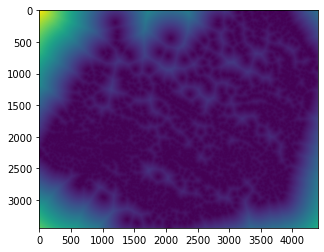

In [35]:
plt.imshow(rasterio.open("intermediate/distance_to_deforestation_in_year_2019.tif").read(1))

### 2.2. Generate template

In [39]:
# Create template file (original file is 10x10 meters, new is 100 x 100, i.e. downscale by factor of 100)

for y in years:
    source = f'{IMAGES_DATA_PATH}/disturbances/forest_change_by_year.tif'
    target = f"intermediate/{y}_template.tif"
    resolution = 20
    template(source, target, resolution)
    
#1. Takes the source raster. 
#2. Changes the resolution of the source, from 10 x 10 to resolution x resolution. Here 20 x 20 meters. 
#3. Creates template rasters, one for each year. 

In [40]:
rasterio.open("intermediate/2019_template.tif").profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 2201, 'height': 1720, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(20.0, 0.0, 603558.1124792217,
       0.0, -20.0, 1742194.128229793), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

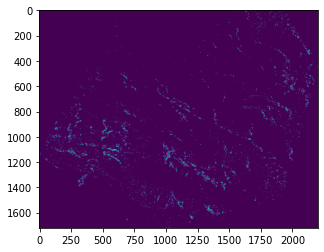

In [41]:
plt.imshow(rasterio.open("intermediate/2019_template.tif").read(1))

### 2.3. Project to template

In [26]:
# project onto template

resample_operations = []
for y in years:
    # Deforestation history
    operation = {'input_file': f'{IMAGES_DATA_PATH}/disturbances/deforestation_{y}.tif",
               'output_file': f"intermediate/deforestation_{y}_ds.tif",
               'resample_method': gdalconst.GRA_Average,
               'data_type': gdalconst.GDT_Float32}
    resample_operations.append(operation)

    # Distance to deforestation
    operation = {'input_file': f'{IMAGES_DATA_PATH}/disturbances/distance_to_deforestation_in_year_{y}.tif",
           'output_file': f"intermediate/distance_to_deforestation_in_year_{y}_ds.tif",
           'resample_method': gdalconst.GRA_Average,
           'data_type': gdalconst.GDT_Float32}
    resample_operations.append(operation)

for o in resample_operations:
    if path.isfile(o['input_file']):

        reproject_raster_to_match_template(o['input_file'], 
                                         o['output_file'], 
                                         o.get('resample_method', None),
                                         o.get('data_type', None),
                                         referencefile = f"intermediate/template.tif"  
                                         )
# Reproject_raster_to_match_template allows us to reproject our different input data (e.g. cover different areas, 
# have different crs, resolution etc) into output data that follow the template's profile. 
# 

AttributeError: 'NoneType' object has no attribute 'GetProjection'

### 2.4. Export to csv

In [7]:
# Write out CVs with all the time variant columns
pathlist = list(Path("intermediate").glob('*_ds.tif'))
for rst in rasters:
    # list of time variant raster names
    time_variant_stems = list(map(lambda y: f"{rst}_deforestation_{y}_ds", years)) + list(map(lambda y: f"distance_to_deforestation_{rst}_in_year_{y}_ds", years)) 
    time_variant_paths = list(filter(lambda p: Path(p).stem  in  time_variant_stems, pathlist))
    # to csv
    headers = []
    output_file_list = []
    for i,p in enumerate(time_variant_paths):
        old_filename = str(p)
        stem = Path(p).stem 
        new_filename = stem + ".csv"


        options = "-plain"

        if(path.isfile(f"intermediate/{rst}/{new_filename}")):
            print('continuing...')
            continue

        command = f"./gdal2xyz.py -csv {options}  {old_filename} intermediate/{rst}/{new_filename}"
        print(command)
        ! $command

## 3. Time invariant features
### 3.1. Resample operations
Define resample operations for each feature

In [8]:
resample_operations = []

# In AOI national and pilot
for rst in rasters:
    cmd = f"gdal_translate -of VRT intermediate/{rst}_template.tif intermediate/{rst}/{rst}_aoi_ds.vrt -a_nodata none"
    os.system(cmd)
    
    cmd = f'gdal_calc.py -A "intermediate/{rst}/{rst}_aoi_ds.vrt" --calc="A*0" --outfile="intermediate/{rst}/{rst}_aoi_ds.tif" --co="COMPRESS=LZW"'
    os.system(cmd)

    if rst =='national':
        path_to_aoi = path.join(IMAGES_DATA_PATH , "Vivid/ERP_Area/ci_limite_frontiere.shp")
    elif rst == 'pilot':
        path_to_aoi = path.join(IMAGES_DATA_PATH , "Vivid/ERP_Area/ERP_Area.shp")
    cmd = f'gdal_rasterize -burn 1 {path_to_aoi} "intermediate/{rst}/{rst}_aoi_ds.tif"'
    os.system(cmd)
    cmd  = f'rm intermediate/{rst}/{rst}_aoi_ds.vrt'
    os.system(cmd)

# Elevation
elevation_operation = {'input_file': path.join(IMAGES_DATA_PATH, "SRTM/srtm_WestAfrica.tif"),
                       'output_file': f"elevation_ds.tif"}
resample_operations.append(elevation_operation)

# Slope
slope_operation = {'input_file': path.join(PREDICTIVE_MODELLING_DATA_PATH, "slope_CDI.tif"),
                   'output_file': f"slope_ds.tif"}
resample_operations.append(slope_operation)

# Roughness
roughness_operation = {'input_file': path.join(PREDICTIVE_MODELLING_DATA_PATH, "roughness_CDI.tif"),
                   'output_file': f"roughness_ds.tif"}
resample_operations.append(roughness_operation)

# Ruggedness (TRI)
ruggedness_operation = {'input_file': path.join(PREDICTIVE_MODELLING_DATA_PATH, "TRI_CDI.tif"),
                       'output_file': f"ruggedness_ds.tif"}
resample_operations.append(ruggedness_operation)

# Cocoa suitability
cocoa_suitability_operation = {'input_file': path.join(IMAGES_DATA_PATH, "Schroth/current_suitability.tif"),
                              'output_file': f"cooa_suitability_ds.tif"}
resample_operations.append(cocoa_suitability_operation)

# Hansen metrics

hansen_treecover_2000_operation = {'input_file': path.join(IMAGES_DATA_PATH, "Vivid/global_forest/Hansen_GFC-2016-v1.4_treecover2000_CDI.tif"),
                                   'output_file': f"treecover_2000_ds.tif"}
resample_operations.append(hansen_treecover_2000_operation)

### Protected status 
# create a .vrt template for each feature of the same shape as template
!gdal_translate -of VRT intermediate/national_template.tif intermediate/protected_areas_ds.vrt -a_nodata none
!gdal_translate -of VRT intermediate/national_template.tif intermediate/national_parks_ds.vrt -a_nodata none
!gdal_translate -of VRT intermediate/national_template.tif intermediate/protected_id.vrt -a_nodata none
# erase all entries inherited from template - set all rasters to 0
!gdal_calc.py -A "intermediate/protected_areas_ds.vrt" --calc="A*0" --outfile="intermediate/protected_areas_ds.tif" --co="COMPRESS=LZW"
!gdal_calc.py -A "intermediate/national_parks_ds.vrt" --calc="A*0" --outfile="intermediate/national_parks_ds.tif" --co="COMPRESS=LZW"
!gdal_calc.py -A "intermediate/protected_id.vrt" --calc="A*0" --outfile="intermediate/protected_id_ds.tif" --co="COMPRESS=LZW"
# write tifs with protected areas 
path_to_protected_areas = path.join(IMAGES_DATA_PATH , "Vivid/protected_areas/all_forests.shp")
path_to_national_parks = path.join(IMAGES_DATA_PATH , "Vivid/protected_areas/pnr_reprojected.shp")

!gdal_rasterize -a OBJECTID_1 $path_to_protected_areas "intermediate/protected_id_ds.tif"
!gdal_rasterize -burn 1 $path_to_protected_areas "intermediate/protected_areas_ds.tif"
!gdal_rasterize -burn 1 $path_to_national_parks "intermediate/national_parks_ds.tif"
#!gdal_rasterize -burn 1 -sql "SELECT * FROM forests WHERE NOM='TAI' OR NOM='N''ZO'" $path_to_protected_areas "intermediate/national_parks_ds.tif"
!rm intermediate/protected_areas_ds.vrt
!rm intermediate/national_parks_ds.vrt
!rm intermediate/protected_id.vrt
protected_status = ['protected_id_ds.tif',
                    'protected_areas_ds.tif',
                    'national_parks_ds.tif'
                   ]
for status in protected_status:
    status_append = {'input_file':f'intermediate/{status}',
                         'output_file': f'{status}'}
    resample_operations.append(status_append)


# Merraclim metrics
for i in range(1,17):
    merraclim_operation = {'input_file': path.join(IMAGES_DATA_PATH, f"MerraClim/2_5m_mean_00s_bio{i}.tif"),
                         'output_file': f"merraclim_{i}_ds.tif"}
    resample_operations.append(merraclim_operation)


# Distance to permanent water
distance_to_permanent_water_operation = {'input_file': path.join(PREDICTIVE_MODELLING_DATA_PATH, "distance_to_permanent_river_CDI.tif"),
                              'output_file': f"distance_to_permanent_river_ds.tif"}
resample_operations.append(distance_to_permanent_water_operation)


# Distance to major road
distance_to_major_road_operation = {'input_file': path.join(PREDICTIVE_MODELLING_DATA_PATH, "distance_to_major_road.tif"),
                              'output_file': f"distance_to_major_road_ds.tif"}
resample_operations.append(distance_to_major_road_operation)


# Distance to road 
distance_to_road_operation = {'input_file': path.join(PREDICTIVE_MODELLING_DATA_PATH, "distance_to_road.tif"),
                              'output_file': f"distance_to_road_ds.tif"}
resample_operations.append(distance_to_road_operation)


#Distance to urban settlement metrics
esa_aggregation_levels = [10,20,50,100,200]
esa_years = [2001,2006,2011,2015]
distances = []
for pair in list(itertools.product(esa_aggregation_levels, esa_years)):
    aggregation, year = pair
    distance_to_urban_settlement_operation = {'input_file': path.join(PREDICTIVE_MODELLING_DATA_PATH, "esa_urban/esa_urban/distance_to_urban_cluster_over_{}_cells_year_{}.tif".format(aggregation,year)),
                                              'output_file': "distance_to_urban_cluster_over_{}_cells_year_{}_ds.tif".format(aggregation,year)
                                             }
    resample_operations.append(distance_to_urban_settlement_operation)

# Predominant land use 2019
predominant_land_use_operation = {'input_file': path.join(IMAGES_DATA_PATH, "Vivid/rsac_land_use/rsac_land_use_CDI.tif"),
                                  'output_file': "predominant_land_use_ds.tif",
                                  'resample_method': gdalconst.GRA_Mode
                                  }
resample_operations.append(predominant_land_use_operation)

#Share closed forest 2019
if(not path.isfile("intermediate/closed_forest_mask.tif")):
    !gdal_calc.py -A "/mnt/uksa-storage/images-cdi-data/Vivid/rsac_land_use/rsac_land_use_CDI.tif" --calc="A==5" --outfile=intermediate/closed_forest_mask.tif --co="COMPRESS=LZW"

share_closed_forest_operation = {'input_file': "intermediate/closed_forest_mask.tif",
                              'output_file': "closed_forest_mask_ds.tif"}
resample_operations.append(share_closed_forest_operation)




Input file size is 6723, 7070
Input file size is 6723, 7070
Input file size is 6723, 7070
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
0 .. 10 .. 20 .. 30 .. 40 .. 50 .. 60 .. 70 .. 80 .. 90 .. 100 - Done
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


### 3.2. Reproject
Compute each resample operation defined above. The computations need to be carried out twice, first for the whole country and then for the South West only.

In [9]:
for rst in rasters:
    for o in resample_operations:
        reproject_raster_to_match_template(o['input_file'], 
                                         f'intermediate/{rst}/{rst}_'+o['output_file'], 
                                         o.get('resample_method', None),
                                         o.get('data_type', None),
                                         f"intermediate/{rst}_template.tif"
                                         )

### 3.3. Export to csv

In [10]:
# Write out a CSV with all the time invariant columns
for rst in rasters:
    # get time invariant file names
    time_invariant_paths = list(Path(f"intermediate/{rst}").glob('*_ds.tif'))
    headers = []
    output_file_list = []
    # convert each invariant file to csv
    for i,p in enumerate(time_invariant_paths):
        old_filename = str(p)
        stem = Path(p).stem 
        new_filename = stem + ".csv"

        if(i == 0):
            headers.append(f"x,y,{stem}")
            print(f"first file processed is {stem}")
            options = ""
        else:
            headers.append(f"{stem}")
            options = "-plain"

        output_file_list.append(f"intermediate/{rst}/{new_filename}")

        if(path.isfile(f"intermediate/{rst}/{new_filename}")):
            print('continuing...')
            continue

        command = f"./gdal2xyz.py -csv {options}  {old_filename} intermediate/{rst}/{new_filename}"
        print(command)
        ! $command
    
    # create a unique csv with all variables as columns
    pending = "pending.csv"
    output_path = f"intermediate/{rst}/time_invariant.csv"
    for i in range(len(output_file_list)):
        print(i)
        head = headers[i]
        file = output_file_list[i]
        ! echo $head > header.csv
        ! cat  header.csv $file > append.csv
        if i ==0:
            ! cp append.csv $output_path
        else:
            ! ~/.cargo/bin/xsv cat columns append.csv $output_path > pending.csv
            ! rm $output_path
            ! mv $pending $output_path




first file processed is pilot_roughness_ds
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
continuing...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
first file processed is national_distance_to_urban_cluster_over_10_cells_year_2015_ds
continuing...


## 4. Merge datasets
### 4.1. Training set

In [11]:
# train datasets
rst ='pilot'
for year in range(2017,2021):
    create_dataset(year, rst)
    merge_variant_invariant(year, rst)


yes: standard output: Broken pipe
yes: standard output: Broken pipe
yes: standard output: Broken pipe
yes: standard output: Broken pipe


### 4.2. Testing sets

In [12]:
# test dataset PILOT REGION
year = 2019
rst = 'pilot'
create_dataset(year, rst)
merge_variant_invariant(year, rst)

yes: standard output: Broken pipe


In [13]:
# test dataset NATIONAL
year = 2020
rst = 'national'
create_dataset(year, rst)
merge_variant_invariant(year, rst)

yes: standard output: Broken pipe
